NomicEmbeddings

Rag with metadata

Human in the loop

--------------------

patients identity hidden from llm

using python Relp for relative month in profile or policy comply

add database to google api

utilities:   
- patients DB creator

steps:
- Create Agents
- Define tools
- Create graph
- Define Agent Nodes
- Define Tool Node
- Define Edge Logic
- Define the Graph
- show the graph
- Invoke
  
- Human in the loop
- Maximum number of steps
- Helper Utilities

# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based system to automate the management and analysis of clinical trial data, ensuring compliance with regulatory standards, and providing comprehensive reports for stakeholders. This pipeline also incorporate human-in-the-loop (HITL) and memory mechanisms to enhance functionality and accuracy.

## Steps and Plan

1. Define the Problem:

Objective: Automate clinical trial data management, analysis, compliance checks, and reporting.

Key Components: Data collection, data analysis, compliance verification, reporting, and human-in-the-loop interventions.

2. Design the Architecture:
**Agents:**
Data Collection Agent: Gathers patient data, trial results, and other relevant information.

Data Analysis Agent: Analyzes the collected data to generate reports on trial outcomes.

Compliance Agent: Ensures all data and processes adhere to regulatory standards.

Reporting Agent: Compiles and presents the analysis findings in comprehensive reports.

Human-in-the-Loop: Integrate a review phase where human experts validate data analysis and compliance checks before final reporting.

Memory: Utilize LangGraph’s memory capabilities to track the progress and history of each trial.

The Clinical Trial Matching Agent is designed to match patients wit	h suitable clinical trials based on their medical history, symptoms, and ongoing treatments. This application helps patients find relevant clinical trials they may be eligible for, improving their chances of accessing new treatments and contributing to medical research.


1. Database Setup
- SQLite Database: Create two databases:
- Patients DB: Stores patient medical history, previous trials, and other relevant data.
- Clinical Trials DB: Contains information about ongoing and upcoming clinical trials, including eligibility criteria.
2. Agents and Tools
- Patient Data Ingestion Agent: Retrieves patient data from the SQLite database or prompts the user to provide missing data.
- Data Validation and Collection Loop: Ensures all required fields are collected using persistence.
- Policy Compliance Agent: Cross-checks patient data with institutional policies.
- Trial Vectorization Agent: Extracts and vectorizes recruiting trials for efficient search.
- Trial Matching Agent: Forms prompts from patient data to search the vector database for potential trial matches.
- Human-in-the-Loop (HIL) Agent: Presents top trial matches to the user for selection.
- Persistence Mechanism: Allows the application to save and resume states, especially useful for collecting patient data and searching trials.

In [1]:
%load_ext autoreload
%autoreload 2
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

# Parameters

In [2]:
from langchain_openai import ChatOpenAI


policy_vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
chromadb_path = "../../chroma_db"
policy_collection = "policy-chroma"
trial_collection = "trial-chroma"

modelID = "gpt-3.5-turbo"
n_retrieved_policies = 6
# n_retries = 6
n_retrieved_trials = 6



model = ChatOpenAI(temperature = 0.0, model=modelID)

In [3]:
# import os

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the sample datasets

## Patients database

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import random

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "trial_completion_date"]
data = []

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

with open('../../source_data/diseases_list.json', 'r') as file:
        trial_diseases =  json.load(file)

list_trial_diseases = list({disease for diseases in trial_diseases.values() for disease in diseases})

other_medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Obesity"]

all_conditions = list(set(list_trial_diseases + other_medical_conditions))

trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(all_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"NCT0{random.randint(1000000, 9999999)}"
        trial_status = random.choice(trial_statuses)
        trial_completion_date = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        trial_completion_date = ""
    if trial_status == "Ongoing":
        trial_completion_date = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, trial_completion_date))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Jane Anderson,73,myeloid leukemia,,,
1,2,Daniel Wilson,37,Anxiety,,,
2,3,Alice Martinez,77,soft tissue sarcoma,,,
3,4,James Brown,34,suicidal ideation,NCT03721463,Completed,2024-02-17
4,5,Daniel Anderson,67,rectal cancer,NCT02080880,Withdrawn,2022-12-09
5,6,Jane Brown,58,soft tissue sarcoma,NCT04311848,Completed,2023-02-26
6,7,Oliver Garcia,60,Depression,,,
7,8,Sophia Martinez,29,ovarian cancer,NCT07127378,Completed,2022-11-11
8,9,John Doe,71,peritoneal cancer,NCT04387775,Completed,2023-12-12
9,10,Emma Smith,55,soft tissue sarcoma,,,


In [5]:
import os
import sqlite3
import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        trial_completion_date TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Jane Anderson,73,myeloid leukemia,None,None,None
1,2,Daniel Wilson,37,Anxiety,None,None,None
2,3,Alice Martinez,77,soft tissue sarcoma,None,None,None
3,4,James Brown,34,suicidal ideation,NCT03721463,Completed,2024-02-17
4,5,Daniel Anderson,67,rectal cancer,NCT02080880,Withdrawn,2022-12-09
5,6,Jane Brown,58,soft tissue sarcoma,NCT04311848,Completed,2023-02-26
6,7,Oliver Garcia,60,Depression,None,None,None
7,8,Sophia Martinez,29,ovarian cancer,NCT07127378,Completed,2022-11-11
8,9,John Doe,71,peritoneal cancer,NCT04387775,Completed,2023-12-12
9,10,Emma Smith,55,soft tissue sarcoma,None,None,None


## Clinical Trials database

In [6]:
import sys
module_dir = os.path.abspath('../../src')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = False
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(4):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Only trials with status recruiting are selected.
The database for trials is saved to ../../data/trials_data.csv 
 It has 30 rows.
---- Sample 1 ----

        Inclusion Criteria:

          1. Patients must have biopsy proven metastatic NSCLC (Stage IV).

          2. Patients must have received first line chemotherapy, from 4-6 cycles, and achieved
             stable disease or a partial response.

          3. Patients receiving first-line erlotinib, gefitinib, or icotinib for EGFR
             mutant-positive for 3 months and achieved stable disease, partial response or
             completely response.

          4. Age 18 to 75 years old.

          5. Patients must have measurable disease at baseline.

          6. The amount of metastatic focus <5.

          7. ECOG score 0-2

          8. Adequate normal organ and marrow function for TKI treatment and radiotherapy.

          9. Patients must has sensitizing EGFR mutation (e.g. exon 19 deletion or exon 21 L858R)

         10. 

# Creating Vectore Stores

## vectorstore for policy database

local embedding via NomicEmbeddings

In [7]:
import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document
import chromadb

vstore_delete = False
markdown_path = "../../source_data/instut_trials_policy.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()


doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

print(len(doc_splits))
doc_splits

persistent_client = chromadb.PersistentClient(path = chromadb_path)

# if chromadb_path exists
if os.path.exists(chromadb_path):
    vectorstore = Chroma(
        client=persistent_client,
        collection_name=policy_collection,
        embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    # vectorstore._collection.count()
else:
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        client=persistent_client,
        collection_name=policy_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
print(vectorstore._collection.count())
doc_splits


12
12


[Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 2. **Medical History Restrictions**\n   - **Severe Heart Disease** (e.g., recent myocardial infarction, heart failure)\n   - **Uncontrolled Diabetes Mellitus**     \n   - **Recent Surgeries**: Patients who have undergone major surgery within the current year are not eligible.   \n   - **Infectious Diseases**: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specificall

In [8]:
retriever_policy = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})
# question = "policy about patient's past trials"
question = "\ntrial_completion_date: 2024-04-01"
docs_retrieved = retriever_policy.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
print(doc_txt)
docs_retrieved

6

#### 3. **Previous Trial Participation**   
   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.
   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.
   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the current year to allow for proper assessment of any delayed adverse effects.
   - **Trial Outcomes**:
     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.
     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.



[Document(page_content='\n#### 3. **Previous Trial Participation**   \n   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.\n   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the current year to allow for proper assessment of any delayed adverse effects.\n   - **Trial Outcomes**:\n     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.\n     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 4. **Medication and Treatment Restrictions**\n   - **Concurrent M

## Vstore for trials

we just work on 3 main categories of cancer, lukemia, and mental health problems as a demo application.

For a more proper application, this must be done with the help of domain specialists.

In [9]:
# from langchain.document_loaders import CSVLoader
# file = '../../data/trials_data.csv'
# df_trials = pd.read_csv(file)
from helper_functions import disease_map

vstore_delete = False

trial_docs = []
for i, row in df_trials.iterrows():
    disease = disease_map(row['diseases'])
    if disease == 'other_conditions':
        continue
    doc = Document(
        page_content=row['criteria'],
        metadata={
            "nctid": row['nctid'],
            "status": row['status'],
            # "why_stop": row['why_stop'],
            # "label": row['label'],
            # "phase": row['phase'],
            "diseases": str(row['diseases']),
            "disease_category": disease[0],
            "drugs": row['drugs'],            
        }
    )
    trial_docs.append(doc)
# trial_docs

print(trial_docs[0].metadata)

list_remove = set()
for i, doc in enumerate(trial_docs):
    if len(doc.page_content)>10000:
        list_remove.add(i)
        # print(doc.metadata)
    if doc.metadata['disease_category'] == 'other_conditions':
        list_remove.add(i)
        # print(doc.metadata)
# remove list_remove indexes from trial_docs
trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]

# print(len(trial_docs[11].page_content))
# trial_docs.pop(11)

persistent_client = chromadb.PersistentClient(path = chromadb_path)


if vstore_delete == True:
    vectorstore_trials.delete_collection()
    trials_vstore_created = False
    vstore_delete = False
    print("vstore deleted")

# if chromadb_path exists
# if trials_vstore_created:

vectorstore_trials = Chroma(
    client=persistent_client,
    collection_name=trial_collection,
    embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                            inference_mode='local'),
)
if vectorstore_trials._collection.count() == 0:
    vectorstore_trials = Chroma.from_documents(
        documents=trial_docs,
        client=persistent_client,
        collection_name=trial_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    trials_vstore_created = True
    print("Vectorstore is created now")
else:
    print("Loading the vectorstore from persistent client")

print(vectorstore_trials._collection.count())
trial_docs


{'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}
Loading the vectorstore from persistent client
18


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Provide written informed consent to participate on the study\r\n\r\n          -  Patients must have a pathologically confirmed diagnosis either at MSKCC or at the\r\n             participating site of stage I-III malignant pleural mesothelioma\r\n\r\n          -  Epithelioid or biphasic histology subtype (Note: patients with biphasic histology can\r\n             have < 10% sarcomatoid)\r\n\r\n          -  No evidence of metastatic disease.\r\n\r\n          -  Patient age ≥ 18 years but ≤ 80 years at the time of consent.\r\n\r\n          -  Karnofsky performance status ≥ 80%\r\n\r\n          -  Pulmonary Function Tests:\r\n\r\n               1. For all patients: DLCO > 40% predicted (corrected for Hgb)\r\n\r\n               2. For patients enrolled post-P/D, only: FEV1 >/= 35% (corrected for Hgb) (Note:\r\n                  patients enrolled prior to P/D will have PFTs repeated pre-IMRT. If this criteria\r\n     

### Retriever Trials

In [10]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

In [11]:
retriever_trials = vectorstore_trials.as_retriever(search_kwargs={"k": n_retrieved_trials})
# question = trial_docs[trail_smp].page_content
question = """
Which trials are relevant to patient who has adenocarcinoma illness?
"""

# question = f"""
# Which trials are relevant to the patient with the following medical history?\n
# patient_profile: {patient_profile}
# """
# nprint(question)

# Which four trials are for patients with mental problem?
# print(trial_docs[trail_smp].metadata['nctid'])
# question = "Inclusion Criteria:\r\n\r\n          1. Subject"
docs_retrieved = retriever_trials.get_relevant_documents(question)
# docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

6
cancer ['prostate cancer']
cancer ['metastatic pancreatic cancer']
cancer ['rectal cancer']
cancer ['colorectal cancer']
cancer ['pancreatic ductal adenocarcinoma']
cancer ['stage iv non-small cell lung cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

# Tools:

In [12]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """

    # config = ensure_config()  # Fetch from the context
    # configuration = config.get("configurable", {})
    # patient_id = configuration.get("patient_id", None)

    # if not patient_id:
    #     raise ValueError("No patient ID given.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results


def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()

In [13]:
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
print(patient_data)
patient_data

{'patient_id': 4, 'name': 'James Brown', 'age': 34, 'medical_history': 'suicidal ideation', 'previous_trials': 'NCT03721463', 'trial_status': 'Completed', 'trial_completion_date': '2024-02-17'}


{'patient_id': 4,
 'name': 'James Brown',
 'age': 34,
 'medical_history': 'suicidal ideation',
 'previous_trials': 'NCT03721463',
 'trial_status': 'Completed',
 'trial_completion_date': '2024-02-17'}

dummy : profile creator llm

In [14]:
def patient_data_to_string(patient_data):
    return " \n ".join([f"{key}: {value}" for key, value in patient_data.items()])

patient_id = 7
patient_data = get_patient_data(patient_id)
patient_data
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}

# patient_medical_history = patient_data_to_string(patient_data)


{'patient_id': 7,
 'name': 'Oliver Garcia',
 'age': 60,
 'medical_history': 'Depression',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

### Profile Creator

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
parser = StrOutputParser()

# def patient_data_to_string(patient_data):
    # return " \n".join([f"{key}: {value}" for key, value in patient_data.items()])

prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggests relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}
if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient is a 60-year-old with a history of depression. No previous trials or '
 'current trial status. Potential trials may include those focusing on new '
 'treatments for depression or mental health interventions.')


In [16]:
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""
# patient_profile: {patient_profile}
# question = """
# Which trials are relevant to the patient with the medical history of myeloid leukemia?
# """
nprint(question)

# docs_retrieved = retriever_trials.get_relevant_documents(question)
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

('\n'
 'Which trials are relevant to the patient with the following medical '
 'history?\n'
 '\n'
 'patient_profile: Patient is a 60-year-old with a history of depression. No '
 'previous trials or current trial status. Potential trials may include those '
 'focusing on new treatments for depression or mental health interventions.\n')
4
mental_health ['suicidal ideation', 'major depressive disorder', 'healthy participants']
mental_health ['generalized anxiety disorder']
cancer ['prostate cancer']
cancer ['metastatic pancreatic cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n        Suicidal Ideation group:\r\n\r\n          1. Any person admitted to the emergency room department after a suicide attempt , defined\r\n             as requiring medical intervention - not just a psychiatrist ( surgical or\r\n             pharmacological treatment but also the need for observation ) .\r\n\r\n          2. The need for medical intervention will be defined by the ER ED physician\r\n\r\n          3. Ages 18-65\r\n\r\n        For the depression group:\r\n\r\n          1. Diagnosed with major depression according to DSM VI.\r\n\r\n          2. Ongoing depression (according to DSM criteria) despite treatment with at least two\r\n             antidepressants in adequate dosages and for longer than three weeks.\r\n\r\n          3. Ages 18-65\r\n\r\n        For the romantic relationship breakup:\r\n\r\n        1. Participants that have experienced a meaningful romantic relationship break-up within\r\n        the

### profile maker

In [17]:
parser = StrOutputParser()
prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggest relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser

# to preserve the patient's private information
if patient_data.get('name'):
    del patient_data['patient_id']
    del patient_data['name']

patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile) # patient_profile

('Patient is a 60-year-old with a history of depression. No previous trials or '
 'current trial status. Potential trials may include those focusing on '
 'depression treatment or mental health interventions.')


### policy checker

In [18]:
import langchain
from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain.prompts import PromptTemplate
from operator import itemgetter

# patient_profile = patient_data_to_string(patient_data)

# print(patient_profile)

langchain.debug = False

question = f"""
Does the following patient profile comply with the institutional policies?\n
{patient_profile}
"""

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

from langchain.chains import RetrievalQA


class comply(BaseModel):
        """Binary score for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trials 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use NA")
        
llm_with_tool = model.with_structured_output(comply)

docs_retrieved = retriever_policy.get_relevant_documents(question)
docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
docs

prompt_policy = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
        Here are the retrieved policies: \n\n {context} \n\n
        Here is the user question: {question} \n
        Use the current date {date}, as the reference date to evaluate time related policies.\n        
        Giving a reason is required only for rejection cases.
        Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
    input_variables=["context", "question"],
)

# date = datetime.now().strftime("%Y-%m-%d")
date = datetime.today().strftime("%B %Y")

chain = prompt_policy | llm_with_tool

if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']

scored_result = chain.invoke(
    {
        "question": question, 
        "context": docs, 
        "date": date
        # "patient_data": patient_data
    }
)
scored_result

comply(binary_score='yes', reason='NA')

### Retrieval Grader

In [19]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
# cancer:22, asthma:4, leukemia: 8, anx disorder: 7
sample_patient_id = 8
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
del patient_data['name']
del patient_data['patient_id']
# patient_data['trial_status'] = 'Complete'
patient_data

{'age': 29,
 'medical_history': 'ovarian cancer',
 'previous_trials': 'NCT07127378',
 'trial_status': 'Completed',
 'trial_completion_date': '2022-11-11'}

In [20]:
# date
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient is a 29-year-old female with a history of ovarian cancer. She has '
 'previously participated in the clinical trial NCT07127378, which has been '
 'completed as of November 11, 2022. Based on her medical history, she may be '
 'eligible for future clinical trials related to ovarian cancer treatment.')


In [21]:
docs = retriever_trial_sq.get_relevant_documents(patient_profile)
for doc in docs:
    print(doc.metadata.get("disease_category"), doc.metadata.get("diseases"))
docs    

cancer ['ovarian cancer', 'fallopian tube', 'primary peritoneal cancer', 'recurrent ovarian cancer']
cancer ['colorectal cancer']
cancer ['stage iv non-small cell lung cancer']
cancer ['metastatic pancreatic cancer']


[Document(page_content="\n        Inclusion Criteria:\r\n\r\n          -  Pathologic diagnosis of ovarian, fallopian tube or primary peritoneal cancer confirmed\r\n             by pathology review at MSK.\r\n\r\n          -  Patients will have relapsed at least once and returned to complete clinical remission\r\n             after additional chemotherapy. Interval surgery is permitted.\r\n\r\n          -  Complete clinical remission is defined as CA-125 within normal limits, examination and\r\n             CT or MRI without objective evidence of disease (non specific abnormalities are\r\n             permitted on radiologic imaging).\r\n\r\n          -  Patients may sign screening consent during recurrence or at time of remission if they\r\n             can start vaccine therapy within 4 months of completing chemotherapy.\r\n\r\n          -  Testing of patient's archived (paraffin embedded, unstained slides) or freshly\r\n             biopsied tumor nodules must be positive for WT1 (Co

In [22]:
from langchain_core.output_parsers import JsonOutputParser

class grade(BaseModel):
        """The result of the trial's relevance check as relevance score and explanation."""

        relevance_score: str        
        explanation: str = Field(description="Reasons to the given relevance score.")        
        further_information: str

prompt_grader = PromptTemplate(
        template=""" 
        You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n
        Your task is to evaluate the relevance of a clinical trial to the given patient's medical profile. \n
        
        
        The clinical trial is related to these diseases: {trial_diseases} \n
        Here are the inclusion and exclusion criteria of the trial: \n\n {document} \n\n
        
        ===============                
        Use the following steps to determine relevance and provide the necessary fields in your response: \n
        1- If the patient's profile meets any exclusion criteria, then the trial is not relevant --> relevance_score = 'No'. \n
        2- If the patient's has or had the trial's inclusion diseases, then it is relevant --> relevance_score = 'Yes'.\n        
                       
        Example 1: 
The patient has Arthritis and the trial is related to pancreatic cancer. --> relevance_score = 'No' \n
        
        Example 2: 
The patient has pancreatic cancer and the trial is also related to carcinoma pancreatic cancer. --> relevance_score = 'Yes' \n

        Example 3: 
The patient has pancreatic cancer and the trial is related to breast cancer or ovarian cancer. --> relevance_score = 'No'. \n 

        Bring your justification in the explanation. \n

        Mention further information that is needed from the patient's medical history related to the trial's criteria \n

        ===============
        Here is the patient's medical profile: {patient_profile} \n\n
        """,
        input_variables=["document", "patient_profile", "trial_diseases"],
    )

llm_with_tool = model.with_structured_output(grade)

retrieval_grader = prompt_grader | llm_with_tool

doc = docs[0]
doc_txt = doc.page_content
trial_diseases = doc.metadata.get("diseases")
trial_score = retrieval_grader.invoke({"patient_profile": patient_profile, "document": doc_txt, "trial_diseases": trial_diseases})

for score in trial_score:
    nprint(score)
nprint(patient_profile)
print(trial_diseases)
print(doc_txt)

('relevance_score', 'Yes')
( 'explanation',
  'The patient has a history of ovarian cancer, which is one of the diseases '
  "included in the clinical trial's scope. This makes the trial relevant to "
  "the patient's medical profile.")
( 'further_information',
  'Additional information needed: 1. Confirmation of complete clinical '
  'remission after chemotherapy. 2. Confirmation of WT1 or NY-ESO-1 protein '
  'expression in the tumor nodules. 3. Confirmation of hematologic and '
  'biochemical parameters meeting the criteria. 4. Confirmation of negative '
  'serum pregnancy test and effective birth control for patients of '
  'childbearing potential.')
('Patient is a 29-year-old female with a history of ovarian cancer. She has '
 'previously participated in the clinical trial NCT07127378, which has been '
 'completed as of November 11, 2022. Based on her medical history, she may be '
 'eligible for future clinical trials related to ovarian cancer treatment.')
['ovarian cancer', 'fall

In [23]:
trial_score
trial_score_dic = dict(trial_score)
trial_score_dic
nctid = 'NCT00785735'
trial_score_dic['nctid'] = nctid
# relevant_trials.append(score)

In [24]:
for score in trial_score:
    nprint(score)
print(doc_txt)

('relevance_score', 'Yes')
( 'explanation',
  'The patient has a history of ovarian cancer, which is one of the diseases '
  "included in the clinical trial's scope. This makes the trial relevant to "
  "the patient's medical profile.")
( 'further_information',
  'Additional information needed: 1. Confirmation of complete clinical '
  'remission after chemotherapy. 2. Confirmation of WT1 or NY-ESO-1 protein '
  'expression in the tumor nodules. 3. Confirmation of hematologic and '
  'biochemical parameters meeting the criteria. 4. Confirmation of negative '
  'serum pregnancy test and effective birth control for patients of '
  'childbearing potential.')

        Inclusion Criteria:

          -  Pathologic diagnosis of ovarian, fallopian tube or primary peritoneal cancer confirmed
             by pathology review at MSK.

          -  Patients will have relapsed at least once and returned to complete clinical remission
             after additional chemotherapy. Interval surgery is pe

# Graph

## State

In [25]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

# from typing import TypedDict

class AgentState(TypedDict):
    patient_prompt: str
    patient_id: int    
    policy_eligible: bool
    rejection_reason: str
    patient_data: dict
    patient_profile: str
    revision_number: int
    max_revisions: int
    policies: List[Document]
    trials: List[Document]
    relevant_trials: list[dict]
    ask_expert: str

## Agent

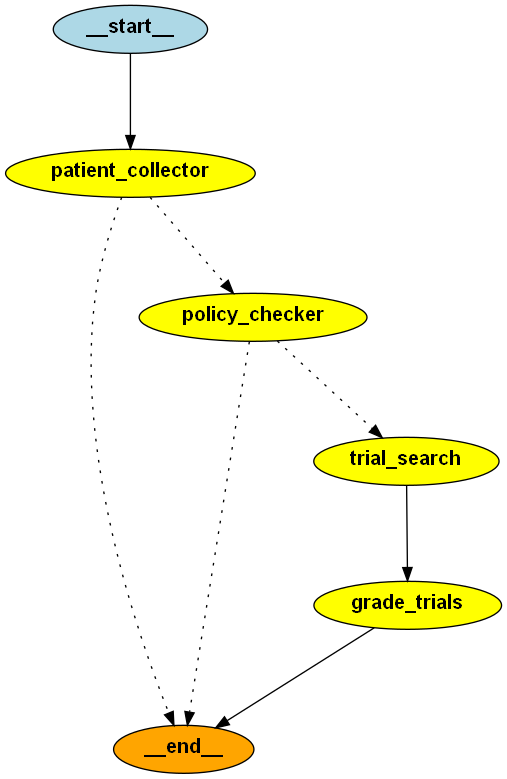

In [69]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel, Field
from operator import itemgetter
from typing import Literal
from langgraph.graph import StateGraph, END


model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")



# ------- Agents:
class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  #reduce inference cost
patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""
# If you cannot find patient ID in the request text then return 10000 as response.

def patient_collector_node(state: AgentState):
    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    # print(response)
    print(f"Patient ID: {patient_id}")
    result = get_patient_data(patient_id)
    
    if result is not None:        
        if patient_data.get('name'):
            del patient_data['patient_id']
            del patient_data['name']
        patient_profile = chain_profile.invoke({'patient_data': patient_data})

    return {
        "patient_data": result,
        "patient_profile": patient_profile,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1
        }


def policy_checker(state: AgentState, docs_retrieved: List[Document] = None):
    # Convert patient_data to string
    
    # parser = StrOutputParser()    
    # patient_data = state['patient_data']        
    
    patient_profile = state['patient_profile']

    question = f"""
    Does the following patient profile comply with the institutional policies?\n
    {patient_profile}
    """

    if docs_retrieved is None:
        docs_retrieved = retriever_policy.get_relevant_documents(question)
    # docs_retrieved
    docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
    # docs

    prompt_policy = PromptTemplate(
        template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
        Here are the retrieved policies: \n\n {context} \n\n
        Here is the user question: {question} \n
        
        Note:Current date is {date}. Use it as the reference date to evaluate time related policies.\n
        Giving a reason is required only for rejection cases.
        Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
        input_variables=["context", "question"],
    )

    # date = datetime.now().strftime("%Y-%m-%d")
    date = datetime.today().strftime("%B %d, %Y")
    
    class comply(BaseModel):
        """score and reason for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use N/A")

        class Config:
            schema_extra = {
                "example": {
                    "binary_score": 'yes',
                    "reason": "N/A",
                },
                "example 2": {
                    "binary_score": 'no',
                    "reason": "The patient is pregnant at the moment.",
                },                
            }
                
    llm_with_tool = model.with_structured_output(comply)

    chain = prompt_policy | llm_with_tool

    # print(f'today is: {date}')
    scored_result = chain.invoke(
        {
            "question": question, 
            "context": docs, 
            "date": date
            # "patient_data": patient_data
        }
    )
    # print(scored_result)
    # scored_result    
    state['policy_eligible'] = True
    if scored_result.binary_score == 'no':
        state['policy_eligible'] = False    
        state['rejection_reason'] = scored_result.reason
        state['ask_expert'] = 'policy_checker'
    
    state['policies'] = docs_retrieved
    state['patient_profile'] = patient_profile
    state["revision_number"] = state.get("revision_number", 1) + 1

    return state

def trial_search(state: AgentState):
    """
    This node searches the trial database to retrieve a list of clinical trials that match the patient's medical history.
    """

    patient_profile = state['patient_profile']

    question = f"""
    Which trials are relevant to the patient with the following medical history?\n
    patient_profile: {patient_profile}
    """        
    docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
    
    return {'trials': docs_retrieved}

def grade_trials(state: AgentState, trials: List[Document] = None):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- ")
    
    if trials is None:
        trials = state['trials']
    patient_profile = state['patient_profile']

    # Score each doc
    relevant_trials = []
    for trial in trials:
        doc_txt = trial.page_content
        trial_diseases = trial.metadata['diseases']
        nctid = trial.metadata['nctid']
        trial_score = retrieval_grader.invoke(
            {
                "patient_profile": patient_profile, 
                "document": doc_txt, 
                "trial_diseases": trial_diseases
            }
        )
            
        relevance_score = trial_score.relevance_score
        if relevance_score.lower() == "yes":
            print(f"---GRADER: TRIAL {nctid} RELEVANT---")            
            trial_score_dic = dict(trial_score)
            trial_score_dic['nctid'] = nctid            
            relevant_trials.append(trial_score_dic)
        else:
            print(f"---GRADER: TRIAL {nctid} NOT RELEVANT---")
    return {
        "relevant_trials": relevant_trials
        }
        
def expert_node(state: AgentState):
    # print(state["ask_expert"])
    # state['revision_number'] = state.get("revision_number", 1) + 1
    # if state['policy_eligible'] == False: 
    #     # print("expert: state['ask_expert'] = 'policy_check'")       
    #     print("Patient's Current Profile:\n")
    #     print(state['patient_profile'])
    #     if input("Do you want to update the patient's profile? (yes/no): ") == "yes":
    #         state['patient_profile'] = input("Enter the updated profile: ")            
    #         print(state['patient_profile'])
    #         state["ask_expert"] = "policy_check"
    #     else:
    #         state['ask_expert'] = END
    # # print(state["ask_expert"])
    # return state
    pass        

# ========= continue functions =========
def should_continue(state: AgentState):
    # end = False
    if state.get("patient_data"):
        # print('patient data found')
        print(state.get("patient_profile", 'No profile generated'))
        return "policy_checker"
    else:
        print('Patient data not found in the database')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        

def should_continue_policy(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')        
        return END

    if state["policy_eligible"]:        
        print("Patient passed the general trials policies")
        return "trial_search"
    else:
        print("Patient did not pass the general trials policies.\n")        
        print('Rejection Reason: ')
        nprint(state['rejection_reason'])
        print("You can correct the patient's medical profile if required.")
        # state['ask_expert'] = 'policy_check'
        # print("state['ask_expert'] = 'policy_check'")
        # return "expert"
        return END

def should_continue_expert(state: AgentState) -> Literal["policy_checker", END]:
    if state["policy_eligible"] == False:
        print('to policy check')
        next = "policy_checker"
        # state["ask_expert"] = ""
    else:
        next = END
        print('to end')
    return next

# ==== define graph nodes====

builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")

builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_checker", policy_checker)
builder.add_node("trial_search", trial_search)
builder.add_node("grade_trials", grade_trials)
# builder.add_node("expert", expert_node)

# retrieve = ToolNode([retriever_tool])
# builder.add_node("retrieve", retrieve)  # retrieval


# ===== define graph edges====
# builder.add_edge("patient_collector", "")
# builder.add_edge("patient_adder", "patient_collector")
builder.add_conditional_edges(
    "patient_collector", 
    should_continue, 
    {END: END
    # "patient_collector": "patient_collector"
    , "policy_checker": "policy_checker"
    # ,"patient_adder": "patient_adder"
    }
)

builder.add_conditional_edges(
    "policy_checker", 
    should_continue_policy, 
    {
    "trial_search": "trial_search"
    # , "expert": "expert"
    , END: END
    }
)


# builder.add_conditional_edges(
#     "expert", 
#     should_continue_expert    
# )

# builder.add_edge("policy_checker", "retrieve")
# builder.add_conditional_edges(
#     "policy_checker", 
#     tools_condition, 
#     {END: END
#     ,"tools": "retrieve"
#     }
# )

builder.add_edge("trial_search", "grade_trials")
# builder.add_edge("grade_trials", END)
builder.set_finish_point("grade_trials")


graph = builder.compile(
    checkpointer=memory
    # ,interrupt_before=["__end__"]
    # , interrupt_after=["expert"]
)

from IPython.display import Image

Image(graph.get_graph().draw_png())



In [27]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 32
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

{'patient_id': 32,
 'name': 'Michael Thomas',
 'age': 77,
 'medical_history': 'Chronic Pain',
 'previous_trials': 'NCT07600953',
 'trial_status': 'Ongoing',
 'trial_completion_date': None}

In [28]:
langchain.debug = False
thread = {"configurable": {"thread_id": "1"}}
for event in graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 3,
    "revision_number": 1,
}, thread):
    print(event)

Patient ID: 32
Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.
{'patient_collector': {'patient_id': 32, 'patient_data': {'patient_id': 32, 'name': 'Michael Thomas', 'age': 77, 'medical_history': 'Chronic Pain', 'previous_trials': 'NCT07600953', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': 'Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.', 'revision_number': 2}}
Patient did not pass the general trials policies.

Rejection Reason: 
"Age exceeds the maximum limit of 75 years set by the institution's policy."
You 

In [39]:
from helper_functions import fn_get_state
states, state_next  = fn_get_state(graph, thread, vernose = False, next = 'policy_checker')
# states[-3].next
state_next = states[-3]
print(state_next.next)
state_next.values['patient_profile']
# state_next.values
# states
# states[0].created_at
# docs = states[0].values['policies']
# docs
# doc = docs[4]
# doc
# nprint(state_next.values['patient_profile'])
# result = policy_checker(state_next.values)
# result['policy_eligible']
# policy_checker(state_next.values, [doc])
# state_next.values
# states[0].values

('policy_checker',)


'Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.'

### HIL

In [41]:
state_next.values['patient_profile'] = """
'Patient is a 74-year-old with a history of Chronic Pain. 
They have previously participated in the clinical trial NCT07600953, which is currently completed. 
Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.'
"""
# nprint(state_next.values['patient_profile'])

branch_state = graph.update_state(state_next.config, state_next.values)
# print(branch_state)

# result = policy_checker(state_next.values)
# result = policy_checker(state_next.values, [doc])
# print(result['policy_eligible'])
# if 'rejection_reason' in result:
    # nprint(result['rejection_reason']) 




'Patient is a 74-year-old with a history of Chronic Pain. 
They have previously participated in the clinical trial NCT07600953, which is currently completed. 
Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.'



Continue from modified state

In [42]:
print("--------- continue from modified state ---------")
events = []
for event in graph.stream(None, branch_state):    
    events.append(event)
    print(event)

--------- continue from modified state ---------
Patient passed the general trials policies
{'policy_checker': {'patient_prompt': 'Is patient 32 eligible for any medical trial?', 'patient_id': 32, 'policy_eligible': True, 'rejection_reason': None, 'patient_data': {'patient_id': 32, 'name': 'Michael Thomas', 'age': 77, 'medical_history': 'Chronic Pain', 'previous_trials': 'NCT07600953', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': "\n'Patient is a 74-year-old with a history of Chronic Pain. \nThey have previously participated in the clinical trial NCT07600953, which is currently completed. \nBased on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.'\n", 'revision_number': 3, 'max_revisions': 3, 'policies': [Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specifie

Let's look at the trials

In [43]:
# if event has the key grade_trials
if "grade_trials" in event:
    if len(event['grade_trials']['relevant_trials'])>0:
        # convert to dataframe
        df_trials_relevant = pd.DataFrame(event['grade_trials']['relevant_trials'])
        for i, row in df_trials_relevant.iterrows():
            print('==== evaluaiton of trial', row['nctid'])
            print('explanation:')
            nprint(row['explanation'])
            print('Required information:')
            nprint(row['further_information'])
else:
    print('The trial_grader was not reached!')

df_trials_relevant



==== evaluaiton of trial NCT02366819
explanation:
('The patient has a history of esophagogastric adenocarcinoma, which is one of '
 "the diseases included in the trial's inclusion criteria. Therefore, the "
 "trial is relevant to the patient's medical profile.")
Required information:
("Additional information needed from the patient's medical history includes "
 'current ECOG performance status, recent blood test results for ANC, '
 'hemoglobin, platelets, total bilirubin, SGOT, SGPT, and creatinine levels. '
 'It would also be important to know if the patient has any concurrent medical '
 'conditions or is taking any medications that may affect eligibility for the '
 'trial.')


,relevance_score,explanation,further_information,nctid
0,Yes,The patient has a history of esophagogastric a...,Additional information needed from the patient...,NCT02366819


In [61]:
states, state_next, state_last = fn_get_state(graph, thread, vernose = False, next = 'policy_checker')
nctid = state_last.values['relevant_trials'][0]['nctid']
df_trials[df_trials['nctid'] == nctid]['diseases'].values[0]
df_trials[df_trials['nctid'] == nctid]['criteria'].values[0]
doc = state_last.values['trials'][-1]
doc

Document(page_content="\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed locally advanced gastric (primary endpoint includes proximal\r\n             and mid-body stomach) or esophagogastric adenocarcinoma; distal gastric (antral)\r\n             adenocarcinomas are eligible for enrolment but will not be included in the primary\r\n             analysis\r\n\r\n          -  Locally advanced disease as determined by endoscopic ultrasound (EUS) stage > primary\r\n             tumor (T) 3 and/or any T, lymph nodes (N)+ disease without metastatic disease (Mx)\r\n\r\n          -  All patients must have diagnostic laparoscopy with diagnostic washings for cytology;\r\n             both cytology positive and negative patients are eligible for enrolment, but only\r\n             cytology negative patients will be included in the primary analyses; gross peritoneal\r\n             disease is not eligible\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performa

In [82]:
# state = states[0].values
state_next = states[1]
# state_next = state_last
state_next.values['patient_profile'] = """
Patient is a 74-year-old with a history of Chronic Pain in the chest. 
They have previously participated in the clinical trial NCT07600953, which is currently completed. 
Based on their medical history, they may be eligible for trials focusing on pain management or chronic chest pain conditions"
"""
result = grade_trials(state_last.values)
result

In [85]:
branch_state = graph.update_state(state_next.config, state_next.values)
print("--------- continue from modified state ---------")
events = []
for event in graph.stream(None, branch_state):    
    events.append(event)
    print(event)


--------- continue from modified state ---------
Patient ID: 32
Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain treatments.
{'patient_collector': {'patient_id': 32, 'patient_data': {'patient_id': 32, 'name': 'Michael Thomas', 'age': 77, 'medical_history': 'Chronic Pain', 'previous_trials': 'NCT07600953', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': 'Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain treatments.', 'revision_number': 4}}
max revision reached
{'policy_checker': {'patient_prompt': 'Is patient 32 eligible for any medical tri

In [78]:
for doc in state_last.values['trials']:
    print(doc.metadata.get("disease_category"), doc.metadata.get("diseases"))

cancer ['ovarian cancer', 'fallopian tube', 'primary peritoneal cancer', 'recurrent ovarian cancer']
cancer ['prostate cancer']
leukemia ['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']
cancer ['esophageal adenocarcinoma', 'gastric adenocarcinoma', 'stage iib gastric cancer', 'stage iiia esophageal adenocarcinoma', 'stage iiia gastric cancer', 'stage iiib esophageal adenocarcinoma', 'stage iiib gastric cancer', 'stage iiic esophageal adenocarcinoma', 'stage iiic gastric cancer']


## HIL
To correct Patient's data to pass the eligibility check.

In [ ]:
state = states[1]
state.values
# for k in state:
#     print(k)


# state.values["patient_data"]['trial_status'] = None
# state.values["patient_data"]['previous_trials'] = None
branch_state = graph.update_state(state.config, state.values)
print(branch_state)
# state


print("--------- continue from modified state ---------")
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

# for event in graph.stream({
#     'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
#     # 'patient_prompt': "Is patient Max eligible for any medical trial?",
#     "max_revisions": 2,
#     "revision_number": 1,
# }, thread):
#     print(event)

patient data found
{'patient_id': 8, 'name': 'James Thomas', 'age': 49, 'medical_history': 'lymphoblastic leukemia', 'previous_trials': 'Trial 18', 'trial_status': 'Completed', 'trial_completion_date': '2023-11-06'}
{'configurable': {'thread_id': '1', 'thread_ts': '1ef31789-5527-6dad-8002-b9d01aab14fd'}}
--------- continue from modified state ---------
today is: 2024-06-23
binary_score='no' reason='The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to enrolling in a new trial.'
Patient did not pass the general trials policies
{'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to

In [ ]:
# s.get("patient_collector")
# graph.get_state(thread).next
# graph.get_state_history(thread)
current_state = graph.get_state(thread)
current_state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
graph.update_state(thread, current_state.values)
# s
# a=10000
# type(a)

InvalidUpdateError: Ambiguous update, specify as_node

In [ ]:
state = states[2]
state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
branch_state = graph.update_state(state.config, state.values)
branch_state

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4f7-19d3-601f-8001-87ae15683d5d'}}

In [ ]:
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

patient_id=100
Patient ID: 100
patient data found
{'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}
max revision reached
{'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2}


# Application GUI

In [ ]:
from helper import ewriter, writer_gui

MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

## Dummy tests

In [ ]:
assert 1==2

     type                  name              tbl_name  rootpage  \
0   table        aircrafts_data        aircrafts_data         2   
1   table         airports_data         airports_data         3   
2   table       boarding_passes       boarding_passes         4   
3   table              bookings              bookings         5   
4   table               flights               flights         6   
5   table                 seats                 seats         7   
6   table        ticket_flights        ticket_flights         8   
7   table               tickets               tickets         9   
8   table           car_rentals           car_rentals     21958   
9   table                hotels                hotels     21961   
10  table  trip_recommendations  trip_recommendations     21962   

                                                  sql  
0   CREATE TABLE "aircrafts_data" (\n"aircraft_cod...  
1   CREATE TABLE "airports_data" (\n"airport_code"...  
2   CREATE TABLE "boarding_